In [1]:
import pandas as pd
from collections import defaultdict
import utils

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
seqs = pd.read_csv('data/Xtr0.csv', header=None, names=['seq'])
labels = pd.read_csv('data/Ytr0.csv')
labels = labels.drop(labels.columns[[0]], axis=1)

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

K-grams: 1


K-grams: 2


K-grams: 3


K-grams: 4


K-grams: 5


K-grams: 6


K-grams: 7


K-grams: 8



Done 


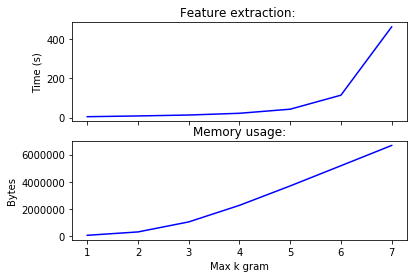

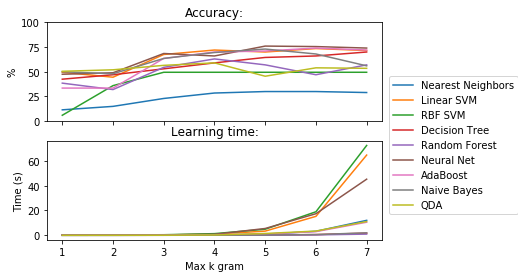

In [3]:
data_creating_time = [0]
data_memory_usage = []
accuracy = defaultdict(list)
learning_time = defaultdict(list)
MAX_GRAM = 8
kgrams = range(1, MAX_GRAM + 1)
features = pd.DataFrame(index=seqs.index)
for kgram in kgrams:
    print('K-grams: ' + str(kgram))
    try:
        start = time.time()
        new_features = pd.DataFrame()
        for index, row in seqs.iterrows():
            sub_seq_dict = defaultdict(lambda :0)
            for i in range(len(row.seq) - kgram):
                sub_seq = row.seq[i:i+kgram]
                sub_seq_dict[sub_seq] +=1
            new_features = new_features.append(sub_seq_dict, ignore_index=True)
        new_features = new_features.fillna(0)  
        new_features.divide(new_features.max(axis=0), axis=1)
        features = features.merge(new_features, left_index=True, right_index=True)
        features = features.to_sparse(fill_value=0)
        time_spent = time.time() - start
        
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)
        results_acc = {}
        results_learning = {}
        for name, clf in zip(names, classifiers):
            start = time.time()
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            # print(name)
            # print('- accuracy: ' + str(score))
            # print('- time: ' + str(time.time() - start))
            results_acc[name] = score
            results_learning[name] = time.time() - start
            
        data_creating_time.append(data_creating_time[-1] + time_spent)
        data_memory_usage.append(features.memory_usage().sum())
        for name in names:
            accuracy[name].append(results_acc[name])
            learning_time[name].append(results_learning[name])
    except Exception as e:
        print(e)
        kgrams = range(1, kgram)
        break
data_creating_time = data_creating_time[1:]
print('Done ')

utils.show_feature_extraction_memory_usage(kgrams, data_creating_time, data_memory_usage, 'limited')
utils.show_accuracy_learning_time(names, kgrams, accuracy, learning_time, 'limited')

limited_kgrams = kgrams
limited_data_creating_time = data_creating_time
limited_data_memory_usage = data_memory_usage
limited_accuracy = accuracy
limited_learning_time = learning_time

In [6]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier()]


K-grams: 1


K-grams: 2


K-grams: 3


K-grams: 4


K-grams: 5


K-grams: 6


K-grams: 7


K-grams: 8


K-grams: 9


K-grams: 10


K-grams: 11


K-grams: 12


K-grams: 13


K-grams: 14


K-grams: 15


Done 


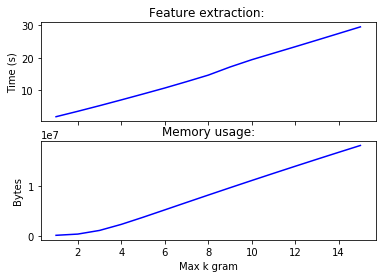

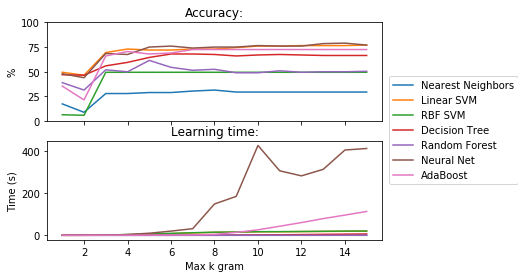

In [7]:
data_creating_time = [0]
data_memory_usage = []
accuracy = defaultdict(list)
learning_time = defaultdict(list)
MAX_GRAM = 15
kgrams = range(1, MAX_GRAM + 1)
features = pd.DataFrame(index=seqs.index).to_sparse(fill_value=0)

feature_set = {}
feature_id = 0
row_idx = []
col_idx = []
data = []
    
for kgram in kgrams:
    print('K-grams: ' + str(kgram))
    try:
        start = time.time()
        for sample, (index, row) in enumerate(seqs.iterrows()):
            local_features = defaultdict(lambda: 0)
            for i in range(len(row.seq) - kgram + 1):
                sub_seq = row.seq[i:i + kgram]
                local_features[sub_seq] += 1
            for key in local_features.keys():
                if key not in feature_set:
                    feature_set[key] = feature_id
                    feature_id += 1
                row_idx.append(sample)
                col_idx.append(feature_set[key])
                data.append(local_features[key])
        features = csr_matrix((data, (row_idx, col_idx)), shape=(len(seqs), feature_id + 1))
        time_spent = time.time() - start
        
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)
        results_acc = {}
        results_learning = {}
        for name, clf in zip(names, classifiers):
            start = time.time()
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            # print(name)
            # print('- accuracy: ' + str(score))
            # print('- time: ' + str(time.time() - start))
            results_acc[name] = score
            results_learning[name] = time.time() - start
            
        data_creating_time.append(data_creating_time[-1] + time_spent)
        data_memory_usage.append(features.data.nbytes + features.indptr.nbytes + features.indices.nbytes)
        for name in names:
            accuracy[name].append(results_acc[name])
            learning_time[name].append(results_learning[name])
    except Exception as e:
        print(e)
        kgrams = range(1, kgram)
        break

print('Done ')

data_creating_time = data_creating_time[1:]
utils.show_feature_extraction_memory_usage( kgrams, data_creating_time, data_memory_usage, 'limited_sparse')
utils.show_accuracy_learning_time(names,kgrams, accuracy, learning_time, 'limited_sparse')
limited_sparse_kgrams = kgrams
limited_sparse_data_creating_time = data_creating_time
limited_sparse_data_memory_usage = data_memory_usage
limited_sparse_accuracy = accuracy
limited_sparse_learning_time = learning_time

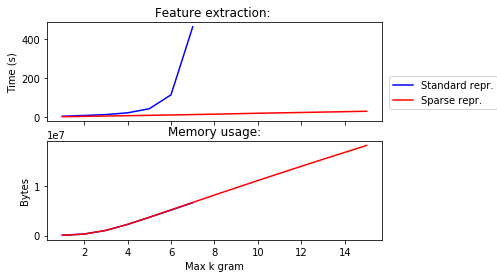

In [ ]:
utils.compare_accuracy_learning_time(limited_kgrams, 
                                     limited_data_creating_time, 
                                     limited_data_memory_usage, 
                                     'Standard repr.',
                                     limited_sparse_kgrams, 
                                     limited_sparse_data_creating_time, 
                                     limited_sparse_data_memory_usage, 
                                     'Sparse repr.',
                                     'normal_sparse')